In [ ]:
!wget -O ./stable_diffusion/stable-diffusion-v1-4/unet/diffusion_pytorch_model.bin https://huggingface.co/CompVis/stable-diffusion-v1-4/resolve/fp16/unet/diffusion_pytorch_model.bin
!wget -O ./stable_diffusion/stable-diffusion-v1-4/vae/diffusion_pytorch_model.bin https://huggingface.co/CompVis/stable-diffusion-v1-4/resolve/fp16/vae/diffusion_pytorch_model.bin
!wget -O ./stable_diffusion/stable-diffusion-v1-4/text_encoder/pytorch_model.bin https://huggingface.co/CompVis/stable-diffusion-v1-4/resolve/fp16/text_encoder/pytorch_model.bin

In [1]:
import json
from collections import OrderedDict
import torch
from stable_diffusion.stable_diffusion import StableDiffusionPipeline
from stable_diffusion.model.clip import CLIPTextModel, CLIPTextConfig
from stable_diffusion.model.tokenizer import CLIPTokenizer
from stable_diffusion.model.autoencoder import AutoencoderKL
from stable_diffusion.model.unet_conditional import UNet2DConditionModel
from stable_diffusion.model.dpmsolver_scheduler import DPMSolverMultistepScheduler
import re
import matplotlib.pyplot as plt
import numpy as np

In [2]:
## Initialize models and load weights

unet_root = "stable_diffusion/stable-diffusion-v1-4/unet/"
vae_root = "stable_diffusion/stable-diffusion-v1-4/vae/"
text_encoder_root = "stable_diffusion/stable-diffusion-v1-4/text_encoder/"
scheduler_root = "stable_diffusion/stable-diffusion-v1-4/scheduler/"
tokenizer_bpe_path = "stable_diffusion/stable-diffusion-v1-4/tokenizer/bpe_simple_vocab_16e6.txt.gz"

with open(unet_root + "config.json", 'r') as f:
    unet_config = json.load(f)
with open(vae_root + "config.json", 'r') as f:
    vae_config = json.load(f)
with open(text_encoder_root + "config.json", 'r') as f:
    text_encoder_config = json.load(f)
with open(scheduler_root + "scheduler_config.json", 'r') as f:
    scheduler_config = json.load(f)


unet = UNet2DConditionModel(**unet_config)
vae = AutoencoderKL(**vae_config)
scheduler = DPMSolverMultistepScheduler(**scheduler_config)
configuration = CLIPTextConfig(**text_encoder_config)
text_encoder = CLIPTextModel(configuration)
tokenizer = CLIPTokenizer(tokenizer_bpe_path)


unet_state_dict = torch.load(unet_root + "diffusion_pytorch_model.bin", map_location='cpu')
unet.load_state_dict(unet_state_dict)

text_encoder_state_dict = torch.load(text_encoder_root + "pytorch_model.bin", map_location='cpu')
text_encoder.load_state_dict(text_encoder_state_dict)

vae_state_dict = torch.load(vae_root + "diffusion_pytorch_model.bin", map_location='cpu')
vae_state_dict_new = OrderedDict()

for k, v in vae_state_dict.items():
    if "mid_block.resnets.0" in k:
        name = k.replace('resnets.0', 'resnets_0')
    elif "mid_block.resnets" in k:
        name = re.sub(r"resnets.(\d+)", lambda match: "resnets." + str(int(match.group(1))-1), k)
    else:
        name = k
    vae_state_dict_new[name] = v

vae.load_state_dict(vae_state_dict_new)

del unet_state_dict, text_encoder_state_dict, vae_state_dict, vae_state_dict_new


diffusion_pipeline = StableDiffusionPipeline(vae, text_encoder, tokenizer, unet, scheduler)

# Generate Sample

In [3]:
DTYPE = torch.float16
DEVICE = torch.device('cuda')
diffusion_pipeline.num_inference_steps = 10

diffusion_pipeline = diffusion_pipeline.to(device=DEVICE, dtype=DTYPE)
diffusion_pipeline.eval();

In [5]:
## Generate sample

with torch.no_grad():
    # with torch.autocast(device_type='cuda', dtype=torch.float16):
    prompt = "a photo of an astronaut riding a horse on mars"
    sample = diffusion_pipeline(prompt)

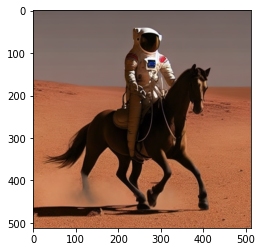

In [6]:
## Visualize sample

import matplotlib.pyplot as plt
import numpy as np

plt.imshow(sample.cpu().float().numpy()[0]/255)

# TorchScript Compilation

In [ ]:
DTYPE = torch.float32
DEVICE = torch.device('cpu')

diffusion_pipeline = diffusion_pipeline.to(device=DEVICE, dtype=DTYPE)
diffusion_pipeline.eval()

with torch.no_grad():
    prompt = "a photo of an astronaut riding a horse on mars"
    torchscript_model = torch.jit.trace(diffusion_pipeline, prompt)

torch.jit.save(torchscript_model, "model_unoptimized.ptl")

In [2]:
# Might need to restart kernel after the previous cell to prevent running out of memory

# Optimize for mobile

from torch.utils.mobile_optimizer import optimize_for_mobile

torchscript_model = torch.jit.load("model_unoptimized.ptl")
torchscript_model_optimized = optimize_for_mobile(torchscript_model)
torch.jit.save(torchscript_model_optimized, "model.ptl")
torchscript_model_optimized._save_for_lite_interpreter("model_lite.ptl")

In [6]:
with torch.no_grad():
    prompt = "a photo of an astronaut riding a horse on mars"
    mobile_output = torchscript_model_optimized(prompt)

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(mobile_output.numpy()[0]/255)